In [1]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 42

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, RadioMaterial, Camera
from sionna.rt.utils import r_hat
from sionna.constants import PI, SPEED_OF_LIGHT
from sionna.utils import expand_to_rank

In [2]:
scene = load_scene(sionna.rt.scene.simple_wedge)

# Create new camera with different configuration
my_cam = Camera("my_cam", position=[10,-100,100], look_at=[10,0,0])
scene.add(my_cam)

if no_preview:
    # Render scene
    scene.render(my_cam);

In [3]:
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [4]:
scene.frequency = 1e9 # 1GHz
scene.objects["wedge"].radio_material = "itu_metal" # Almost perfect reflector

In [5]:
# Configure the antenna arrays used by the transmitters and receivers
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

scene.rx_array = scene.tx_array

In [6]:
# Transmitter
tx_angle = 30/180*PI # Angle phi from the 0-face
tx_dist = 50 # Distance from the edge
tx_pos = 50*r_hat(PI/2, tx_angle)
ref_boundary = (PI - tx_angle)/PI*180
los_boundary = (PI + tx_angle)/PI*180
scene.add(Transmitter(name="tx",
                      position=tx_pos,
                      orientation=[0,0,0]))

# Receivers
# We place num_rx receivers uniformly spaced on the segment of a circle around the wedge
num_rx = 1000 # Number of receivers
rx_dist = 5 # Distance from the edge
phi = tf.linspace(1e-2, 3/2*PI-1e-2, num=num_rx)
theta = PI/2*tf.ones_like(phi)
rx_pos = rx_dist*r_hat(theta, phi)

for i, pos in enumerate(rx_pos):
    scene.add(Receiver(name=f"rx-{i}",
                       position=pos,
                       orientation=[0,0,0]))

In [7]:
# Render scene
my_cam.position = [-30,100,100]
my_cam.look_at([10,0,0])
if no_preview:
    scene.render(my_cam);

In [8]:
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…

In [9]:
# Compute paths between the transmitter and all receivers
paths = scene.compute_paths(num_samples=1e6,
                            los=True,
                            reflection=True,
                            diffraction=True,
                            scattering=False)

# Obtain channel impulse responses
# We squeeze irrelevant dimensions
# [num_rx, max_num_paths]
a, tau = [np.squeeze(t) for t in paths.cir()]

In [10]:

def compute_gain(a, tau):
        """Compute $|H(f)|^2 at f = 0 where H(f) is the baseband channel frequency response"""
        a = tf.squeeze(a, axis=-1)
        h_f_2 = tf.math.abs(tf.reduce_sum(a, axis=-1))**2
        h_f_2 = tf.where(h_f_2==0, 1e-24, h_f_2)
        g_db = 10*np.log10(h_f_2)
        return tf.squeeze(g_db)

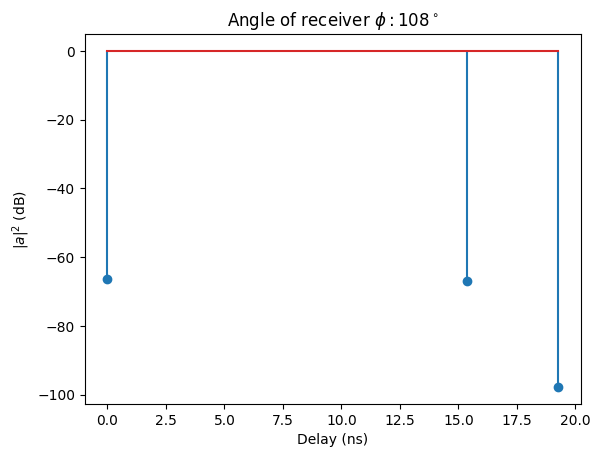

In [11]:
n = 400
plt.figure()
plt.stem(tau[n]/1e-9, 10*np.log10(np.abs(a[n])**2))
plt.title(f"Angle of receiver $\phi: {int(phi[n]/PI*180)}^\circ$");
plt.xlabel("Delay (ns)");
plt.ylabel("$|a|^2$ (dB)");

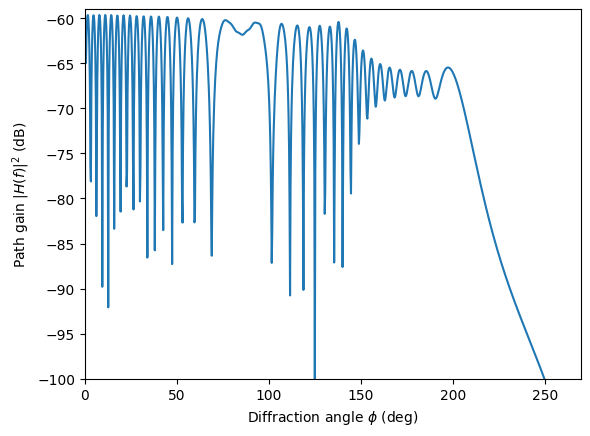

In [13]:
h_f_tot = np.sum(a, axis=-1)def plot(frequency, material):
    """Plots the path gain $|H(f)|^2 versus $phi$ for a given
       frequency and RadioMaterial of the wedge.
    """
    # Set carrier frequency and material of the wedge
    # You can see a list of available materials by executing
    # scene.radio_materials
    scene.frequency = frequency
    scene.objects["wedge"].radio_material = material

    # Recompute paths with the updated material and frequency
    paths = scene.compute_paths(num_samples=1e6,
                                los=True,
                                reflection=True,
                                diffraction=True,
                                scattering=False)

    def compute_gain(a, tau):
        """Compute $|H(f)|^2 are f = 0 where H(f) is the baseband channel frequency response"""
        a = tf.squeeze(a, axis=-1)
        h_f_2 = tf.math.abs(tf.reduce_sum(a, axis=-1))**2
        h_f_2 = tf.where(h_f_2==0, 1e-24, h_f_2)
        g_db = 10*np.log10(h_f_2)
        return tf.squeeze(g_db)

    # Compute gain for all path types
    g_tot_db = compute_gain(*paths.cir())
    g_los_db = compute_gain(*paths.cir(reflection=False, diffraction=False, scattering=False))
    g_ref_db = compute_gain(*paths.cir(los=False, diffraction=False, scattering=False))
    g_dif_db = compute_gain(*paths.cir(los=False, reflection=False, scattering=False))

    # Make a nice plot
    fig = plt.figure()
    phi_deg = phi/PI*180
    ymax = np.max(g_tot_db)+5
    ymin = ymax - 45
    plt.plot(phi_deg, g_tot_db)
    plt.plot(phi_deg, g_los_db)
    plt.plot(phi_deg, g_ref_db)
    plt.plot(phi_deg, g_dif_db)
    plt.ylim([ymin, ymax])
    plt.xlim([phi_deg[0], phi_deg[-1]]);
    plt.legend(["Total", "LoS", "Reflected", "Diffracted"], loc="lower left")
    plt.xlabel("Diffraction angle $\phi$ (deg)")
    plt.ylabel("Path gain $|H(f)|^2$ (dB)")
    ax = fig.axes[0]
    ax.axvline(x=ref_boundary, ymin=0, ymax=1, color="black", linestyle="--")
    ax.axvline(x=los_boundary, ymin=0, ymax=1, color="black", linestyle="--")
    ax.text(ref_boundary-10,ymin+5,'RSB',rotation=90,va='top')
    ax.text(los_boundary-10,ymin+5,'ISB',rotation=90,va='top')
    ax.text(ref_boundary/2,ymax-2.5,'Region I', ha='center', va='center',
            bbox=dict(facecolor='none', edgecolor='black', pad=4.0))
    ax.text(los_boundary-(los_boundary-ref_boundary)/2,ymax-2.5,'Region II', ha='center', va='center',
            bbox=dict(facecolor='none', edgecolor='black', pad=4.0))
    ax.text(phi_deg[-1]-(phi_deg[-1]-los_boundary)/2,ymax-2.5,'Region III', ha='center', va='center',
            bbox=dict(facecolor='none', edgecolor='black', pad=4.0))
    plt.title('$f={}$ GHz ("{}")'.format(frequency/1e9, material))
    plt.tight_layout()
    return fig
fig = plt.figure()
plt.plot(phi/PI*180, 20*np.log10(np.abs(h_f_tot)))
plt.xlabel("Diffraction angle $\phi$ (deg)");
plt.ylabel(r"Path gain $|H(f)|^2$ (dB)");
plt.ylim([-100, -59]);
plt.xlim([0, phi[-1]/PI*180]);

In [14]:
def plot(frequency, material):
    """Plots the path gain $|H(f)|^2 versus $phi$ for a given
       frequency and RadioMaterial of the wedge.
    """
    # Set carrier frequency and material of the wedge
    # You can see a list of available materials by executing
    # scene.radio_materials
    scene.frequency = frequency
    scene.objects["wedge"].radio_material = material

    # Recompute paths with the updated material and frequency
    paths = scene.compute_paths(num_samples=1e6,
                                los=True,
                                reflection=True,
                                diffraction=True,
                                scattering=False)

    def compute_gain(a, tau):
        """Compute $|H(f)|^2 are f = 0 where H(f) is the baseband channel frequency response"""
        a = tf.squeeze(a, axis=-1)
        h_f_2 = tf.math.abs(tf.reduce_sum(a, axis=-1))**2
        h_f_2 = tf.where(h_f_2==0, 1e-24, h_f_2)
        g_db = 10*np.log10(h_f_2)
        return tf.squeeze(g_db)

    # Compute gain for all path types
    g_tot_db = compute_gain(*paths.cir())
    g_los_db = compute_gain(*paths.cir(reflection=False, diffraction=False, scattering=False))
    g_ref_db = compute_gain(*paths.cir(los=False, diffraction=False, scattering=False))
    g_dif_db = compute_gain(*paths.cir(los=False, reflection=False, scattering=False))

    # Make a nice plot
    fig = plt.figure()
    phi_deg = phi/PI*180
    ymax = np.max(g_tot_db)+5
    ymin = ymax - 45
    plt.plot(phi_deg, g_tot_db)
    plt.plot(phi_deg, g_los_db)
    plt.plot(phi_deg, g_ref_db)
    plt.plot(phi_deg, g_dif_db)
    plt.ylim([ymin, ymax])
    plt.xlim([phi_deg[0], phi_deg[-1]]);
    plt.legend(["Total", "LoS", "Reflected", "Diffracted"], loc="lower left")
    plt.xlabel("Diffraction angle $\phi$ (deg)")
    plt.ylabel("Path gain $|H(f)|^2$ (dB)")
    ax = fig.axes[0]
    ax.axvline(x=ref_boundary, ymin=0, ymax=1, color="black", linestyle="--")
    ax.axvline(x=los_boundary, ymin=0, ymax=1, color="black", linestyle="--")
    ax.text(ref_boundary-10,ymin+5,'RSB',rotation=90,va='top')
    ax.text(los_boundary-10,ymin+5,'ISB',rotation=90,va='top')
    ax.text(ref_boundary/2,ymax-2.5,'Region I', ha='center', va='center',
            bbox=dict(facecolor='none', edgecolor='black', pad=4.0))
    ax.text(los_boundary-(los_boundary-ref_boundary)/2,ymax-2.5,'Region II', ha='center', va='center',
            bbox=dict(facecolor='none', edgecolor='black', pad=4.0))
    ax.text(phi_deg[-1]-(phi_deg[-1]-los_boundary)/2,ymax-2.5,'Region III', ha='center', va='center',
            bbox=dict(facecolor='none', edgecolor='black', pad=4.0))
    plt.title('$f={}$ GHz ("{}")'.format(frequency/1e9, material))
    plt.tight_layout()
    return fig

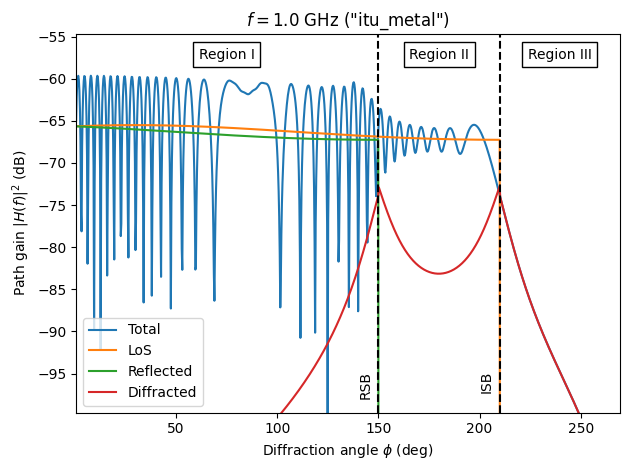

In [15]:
plot(1e9, "itu_metal");

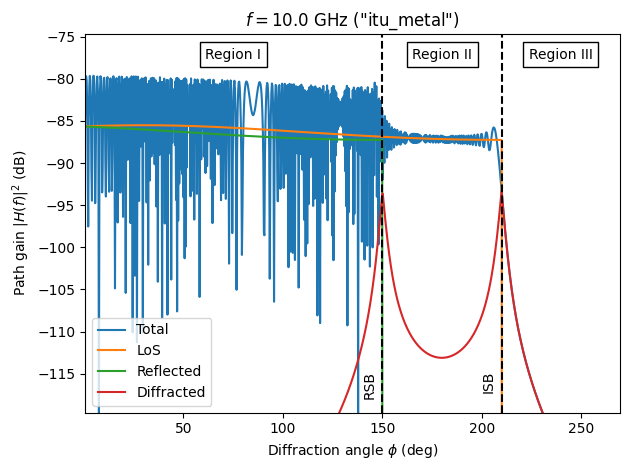

In [16]:
plot(10e9, "itu_metal");

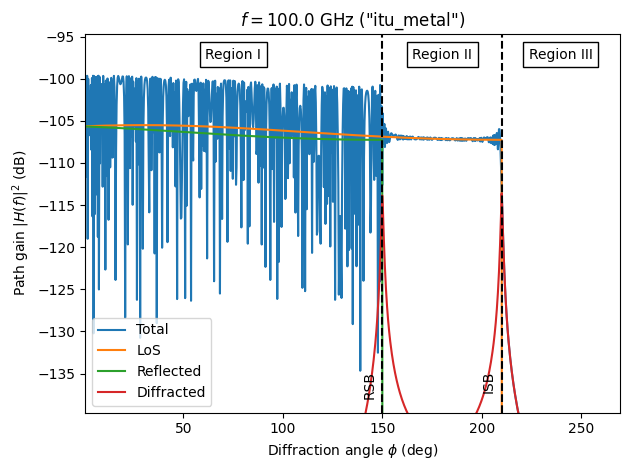

In [17]:
plot(100e9, "itu_metal");

In [18]:
list(scene.radio_materials.keys())

['vacuum',
 'itu_concrete',
 'itu_brick',
 'itu_plasterboard',
 'itu_wood',
 'itu_glass',
 'itu_ceiling_board',
 'itu_chipboard',
 'itu_plywood',
 'itu_marble',
 'itu_floorboard',
 'itu_metal',
 'itu_very_dry_ground',
 'itu_medium_dry_ground',
 'itu_wet_ground']

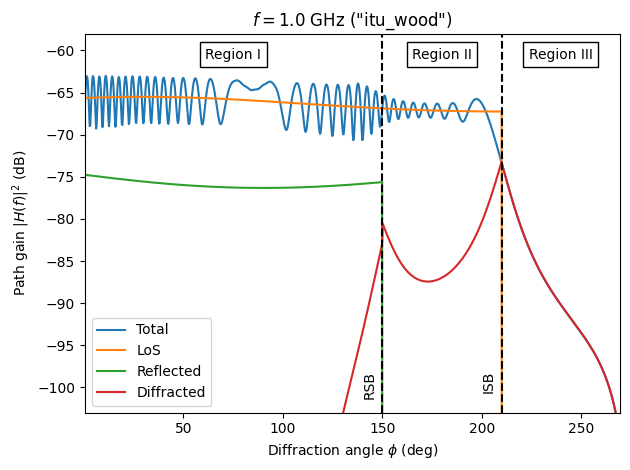

In [19]:
plot(1e9, "itu_wood");

In [20]:
scene.preview()

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, matrixWorldNeedsUpda…